In [1]:
import os
import argparse
import time
import datetime
from tqdm import tqdm

from munch import Munch
from torch.backends import cudnn
import torch
import numpy as np

from core.my_loader import get_train_loader, get_test_loader, InputFetcher
from core.my_solver import Solver
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader

from easydict import EasyDict as edict
from core.my_solver import compute_d_loss, compute_g_loss, moving_average, adv_loss, r1_reg, Sampler, LoaderSampler, tensor2img
from core.my_metrics import get_Z_pushed_loader_stats
from core.fid_score import calculate_frechet_distance

from IPython.display import clear_output
import matplotlib.pyplot as plt

def str2bool(v):
    return v.lower() in ('true')


def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

args = edict({
    'img_size': 128,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'train', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/ot/data/outdoor2church_train',
    'val_img_dir': '/cache/selikhanovych/ot/data/outdoor2church_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': '/cache/selikhanovych/ot/checkpoints/stargan-v2/stargan-v2/outdoor_church_128/checkpoints',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'church',
    'OUTPUT_PATH': '/cache/selikhanovych/ot/checkpoints/stargan-v2/outdoor_church_128',
    'domains': {
        'source': 'outdoor',
        'target': 'church',
    },
    'train_a': '/cache/selikhanovych/ot/data/outdoor2church_train_outdoor',
    'train_b': '/cache/selikhanovych/ot/data/outdoor2church_train_church', 
    'test_a': '/cache/selikhanovych/ot/data/outdoor2church_test_outdoor',
    'test_b': '/cache/selikhanovych/ot/data/outdoor2church_test_church',
    
    'n_epochs': 1
})


eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)
print(domains)

0 0
['church', 'outdoor']


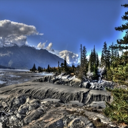

In [2]:
from PIL import Image
from glob import glob

path_to_image = "/cache/selikhanovych/ot/data/outdoor2church_train/outdoor"
images = glob(os.path.join(path_to_image, "*"))

Image.open(images[100])

In [4]:
cudnn.benchmark = True
torch.manual_seed(args.seed)

solver = Solver(args)
assert len(subdirs(args.train_img_dir)) == args.num_domains
assert len(subdirs(args.val_img_dir)) == args.num_domains
loaders = Munch(src=get_train_loader(root=args.train_img_dir,
                                     which='source',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                ref=get_train_loader(root=args.train_img_dir,
                                     which='reference',
                                     img_size=args.img_size,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers),
                val=get_test_loader(root=args.val_img_dir,
                                    img_size=args.img_size,
                                    batch_size=args.val_batch_size,
                                    shuffle=False,
                                    num_workers=args.num_workers))

Number of parameters of generator: 33632003
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20799744
Number of parameters of discriminator: 20735106
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader to fetch source images during the training phase...
Preparing DataLoader to fetch reference images during the training phase...
Preparing DataLoader for the generation phase...


Computing FID


  0%|          | 0/406 [00:00<?, ?it/s]

Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church
Preparing DataLoader for the generation phase...


100%|██████████| 406/406 [01:45<00:00,  3.85it/s]


FID = 17.490852493702448, best FID = 18.789257420739204, best iter = 24000
Plotting, iter = 28000
mode = train


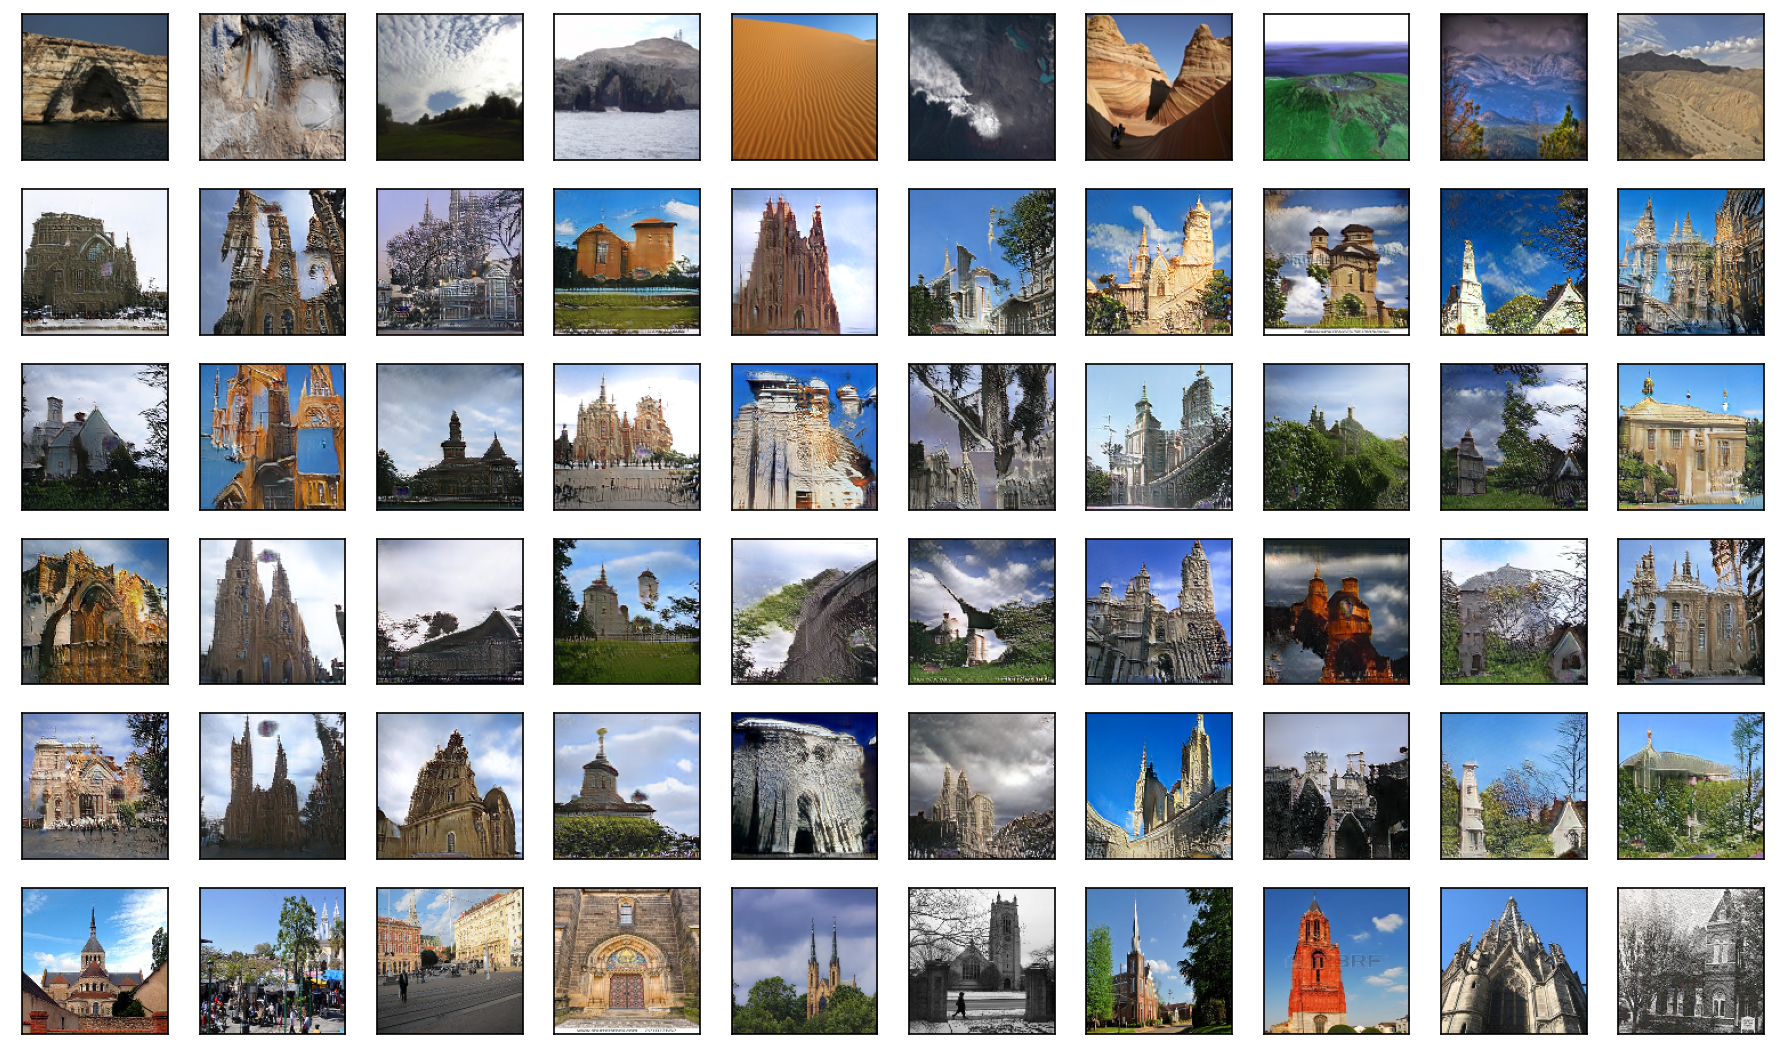

mode = test


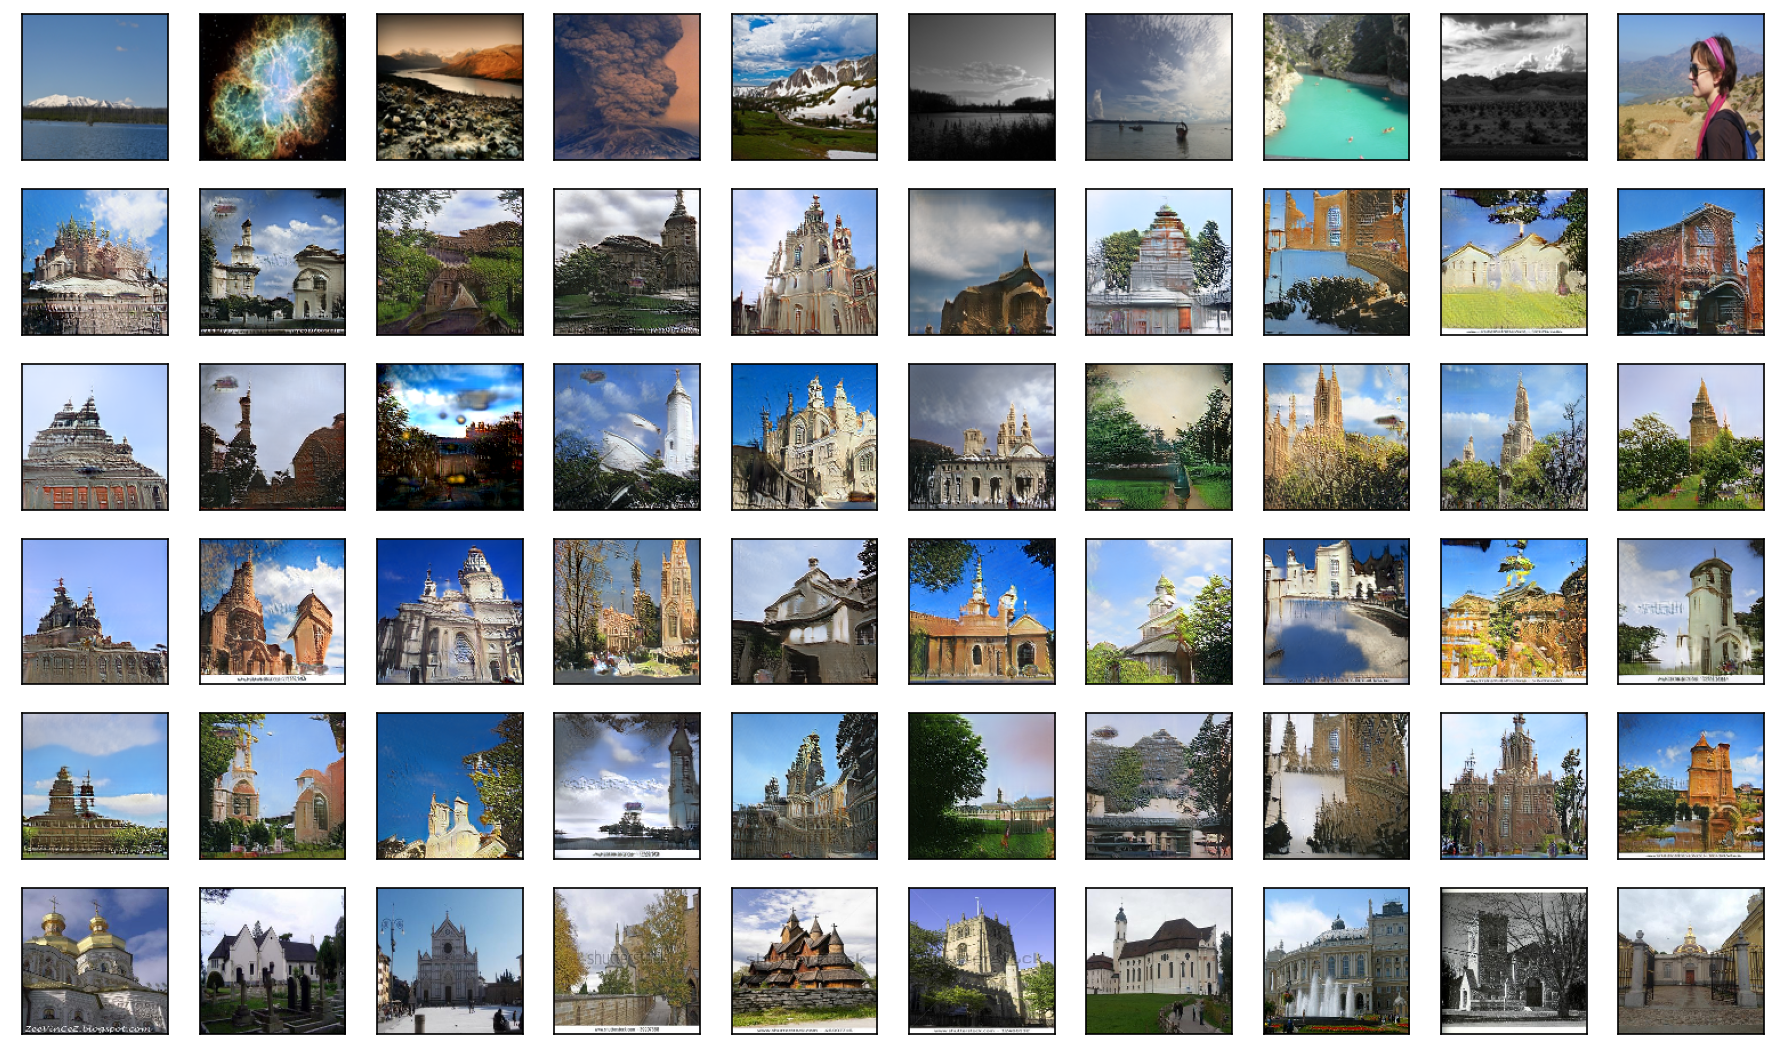

Elapsed time [23:01:13], Iteration [28011/100000], D/latent_real: [0.6947] D/latent_fake: [0.4502] D/latent_reg: [0.0813] D/ref_real: [0.2382] D/ref_fake: [0.4791] D/ref_reg: [0.0683] G/latent_adv: [1.8453] G/latent_sty: [0.2675] G/latent_ds: [0.4980] G/latent_cyc: [0.2618] G/ref_adv: [1.7544] G/ref_sty: [0.1912] G/ref_ds: [0.5118] G/ref_cyc: [0.2500] G/lambda_ds: [0.7199]
Elapsed time [23:01:46], Iteration [28021/100000], D/latent_real: [0.8259] D/latent_fake: [0.2097] D/latent_reg: [0.0921] D/ref_real: [0.1874] D/ref_fake: [0.4060] D/ref_reg: [0.0771] G/latent_adv: [2.3448] G/latent_sty: [0.2224] G/latent_ds: [0.6152] G/latent_cyc: [0.2740] G/ref_adv: [2.1906] G/ref_sty: [0.1285] G/ref_ds: [0.5524] G/ref_cyc: [0.2612] G/lambda_ds: [0.7198]
Elapsed time [23:02:19], Iteration [28031/100000], D/latent_real: [0.9362] D/latent_fake: [0.3307] D/latent_reg: [0.1075] D/ref_real: [0.1460] D/ref_fake: [0.7089] D/ref_reg: [0.0846] G/latent_adv: [2.3497] G/latent_sty: [0.2583] G/latent_ds: [0.48

Elapsed time [23:13:05], Iteration [28231/100000], D/latent_real: [0.7836] D/latent_fake: [0.2738] D/latent_reg: [0.0659] D/ref_real: [0.1724] D/ref_fake: [0.5854] D/ref_reg: [0.0512] G/latent_adv: [1.8278] G/latent_sty: [0.2389] G/latent_ds: [0.5113] G/latent_cyc: [0.2698] G/ref_adv: [1.9936] G/ref_sty: [0.1202] G/ref_ds: [0.5729] G/ref_cyc: [0.2663] G/lambda_ds: [0.7177]
Elapsed time [23:13:37], Iteration [28241/100000], D/latent_real: [0.9299] D/latent_fake: [0.4064] D/latent_reg: [0.0909] D/ref_real: [0.2717] D/ref_fake: [0.5385] D/ref_reg: [0.0645] G/latent_adv: [1.8519] G/latent_sty: [0.2680] G/latent_ds: [0.5458] G/latent_cyc: [0.2719] G/ref_adv: [1.6712] G/ref_sty: [0.1844] G/ref_ds: [0.4237] G/ref_cyc: [0.2564] G/lambda_ds: [0.7176]
Elapsed time [23:14:10], Iteration [28251/100000], D/latent_real: [0.7711] D/latent_fake: [0.3139] D/latent_reg: [0.0908] D/ref_real: [0.2118] D/ref_fake: [0.6874] D/ref_reg: [0.0776] G/latent_adv: [1.8664] G/latent_sty: [0.2340] G/latent_ds: [0.50

Elapsed time [23:25:03], Iteration [28451/100000], D/latent_real: [0.6896] D/latent_fake: [0.1835] D/latent_reg: [0.1149] D/ref_real: [0.0451] D/ref_fake: [1.1776] D/ref_reg: [0.0582] G/latent_adv: [3.1477] G/latent_sty: [0.2505] G/latent_ds: [0.5546] G/latent_cyc: [0.2761] G/ref_adv: [3.1460] G/ref_sty: [0.1340] G/ref_ds: [0.5732] G/ref_cyc: [0.2621] G/lambda_ds: [0.7155]
Elapsed time [23:25:35], Iteration [28461/100000], D/latent_real: [0.5593] D/latent_fake: [0.5677] D/latent_reg: [0.0902] D/ref_real: [0.2433] D/ref_fake: [0.3695] D/ref_reg: [0.0900] G/latent_adv: [1.8223] G/latent_sty: [0.2436] G/latent_ds: [0.6166] G/latent_cyc: [0.2539] G/ref_adv: [1.7142] G/ref_sty: [0.1191] G/ref_ds: [0.5057] G/ref_cyc: [0.2456] G/lambda_ds: [0.7154]
Elapsed time [23:26:07], Iteration [28471/100000], D/latent_real: [0.7480] D/latent_fake: [0.4397] D/latent_reg: [0.0683] D/ref_real: [0.3103] D/ref_fake: [0.5831] D/ref_reg: [0.0642] G/latent_adv: [1.8163] G/latent_sty: [0.2312] G/latent_ds: [0.61

Elapsed time [23:36:59], Iteration [28671/100000], D/latent_real: [1.1484] D/latent_fake: [0.1739] D/latent_reg: [0.0733] D/ref_real: [0.1626] D/ref_fake: [0.7316] D/ref_reg: [0.0576] G/latent_adv: [1.6255] G/latent_sty: [0.2389] G/latent_ds: [0.5457] G/latent_cyc: [0.2485] G/ref_adv: [1.7152] G/ref_sty: [0.1261] G/ref_ds: [0.4709] G/ref_cyc: [0.2500] G/lambda_ds: [0.7133]
Elapsed time [23:37:31], Iteration [28681/100000], D/latent_real: [0.6347] D/latent_fake: [0.4082] D/latent_reg: [0.0817] D/ref_real: [0.2092] D/ref_fake: [0.4858] D/ref_reg: [0.0765] G/latent_adv: [1.6570] G/latent_sty: [0.2283] G/latent_ds: [0.5611] G/latent_cyc: [0.2936] G/ref_adv: [1.5884] G/ref_sty: [0.1465] G/ref_ds: [0.4465] G/ref_cyc: [0.2865] G/lambda_ds: [0.7132]
Elapsed time [23:38:04], Iteration [28691/100000], D/latent_real: [1.1187] D/latent_fake: [0.1873] D/latent_reg: [0.0801] D/ref_real: [0.1474] D/ref_fake: [0.8042] D/ref_reg: [0.0549] G/latent_adv: [1.3887] G/latent_sty: [0.2716] G/latent_ds: [0.53

Elapsed time [23:49:01], Iteration [28891/100000], D/latent_real: [0.5513] D/latent_fake: [0.3258] D/latent_reg: [0.0926] D/ref_real: [0.1465] D/ref_fake: [0.4673] D/ref_reg: [0.0906] G/latent_adv: [2.8219] G/latent_sty: [0.2414] G/latent_ds: [0.5730] G/latent_cyc: [0.2953] G/ref_adv: [2.5632] G/ref_sty: [0.1543] G/ref_ds: [0.5005] G/ref_cyc: [0.2800] G/lambda_ds: [0.7111]
Elapsed time [23:49:33], Iteration [28901/100000], D/latent_real: [0.8864] D/latent_fake: [0.2269] D/latent_reg: [0.0727] D/ref_real: [0.1928] D/ref_fake: [0.5748] D/ref_reg: [0.0648] G/latent_adv: [2.0278] G/latent_sty: [0.2352] G/latent_ds: [0.5533] G/latent_cyc: [0.2192] G/ref_adv: [1.9779] G/ref_sty: [0.1390] G/ref_ds: [0.5382] G/ref_cyc: [0.2191] G/lambda_ds: [0.7110]
Elapsed time [23:50:06], Iteration [28911/100000], D/latent_real: [0.7635] D/latent_fake: [0.3813] D/latent_reg: [0.0870] D/ref_real: [0.2499] D/ref_fake: [0.6437] D/ref_reg: [0.0825] G/latent_adv: [2.3537] G/latent_sty: [0.2457] G/latent_ds: [0.51

Elapsed time [1 day, 0:00:59], Iteration [29111/100000], D/latent_real: [0.7913] D/latent_fake: [0.3482] D/latent_reg: [0.0819] D/ref_real: [0.2030] D/ref_fake: [0.5585] D/ref_reg: [0.0692] G/latent_adv: [1.8892] G/latent_sty: [0.2629] G/latent_ds: [0.5049] G/latent_cyc: [0.2265] G/ref_adv: [1.8289] G/ref_sty: [0.1224] G/ref_ds: [0.5485] G/ref_cyc: [0.2265] G/lambda_ds: [0.7089]
Elapsed time [1 day, 0:01:31], Iteration [29121/100000], D/latent_real: [0.6310] D/latent_fake: [0.4872] D/latent_reg: [0.0751] D/ref_real: [0.2745] D/ref_fake: [0.5126] D/ref_reg: [0.0770] G/latent_adv: [1.8541] G/latent_sty: [0.2410] G/latent_ds: [0.4919] G/latent_cyc: [0.2643] G/ref_adv: [1.7568] G/ref_sty: [0.1371] G/ref_ds: [0.5925] G/ref_cyc: [0.2502] G/lambda_ds: [0.7088]
Elapsed time [1 day, 0:02:04], Iteration [29131/100000], D/latent_real: [1.1545] D/latent_fake: [0.2171] D/latent_reg: [0.0976] D/ref_real: [0.1207] D/ref_fake: [0.8859] D/ref_reg: [0.0679] G/latent_adv: [1.7109] G/latent_sty: [0.2354] 

Elapsed time [1 day, 0:12:55], Iteration [29331/100000], D/latent_real: [1.1549] D/latent_fake: [0.1604] D/latent_reg: [0.0902] D/ref_real: [0.1653] D/ref_fake: [0.9497] D/ref_reg: [0.0510] G/latent_adv: [1.6796] G/latent_sty: [0.2452] G/latent_ds: [0.5527] G/latent_cyc: [0.2434] G/ref_adv: [1.6677] G/ref_sty: [0.1332] G/ref_ds: [0.4873] G/ref_cyc: [0.2359] G/lambda_ds: [0.7067]
Elapsed time [1 day, 0:13:30], Iteration [29341/100000], D/latent_real: [0.9080] D/latent_fake: [0.2792] D/latent_reg: [0.0968] D/ref_real: [0.0875] D/ref_fake: [0.6097] D/ref_reg: [0.0802] G/latent_adv: [2.1941] G/latent_sty: [0.2448] G/latent_ds: [0.5061] G/latent_cyc: [0.2452] G/ref_adv: [2.0077] G/ref_sty: [0.1277] G/ref_ds: [0.5261] G/ref_cyc: [0.2507] G/lambda_ds: [0.7066]
Elapsed time [1 day, 0:14:04], Iteration [29351/100000], D/latent_real: [0.8497] D/latent_fake: [0.3431] D/latent_reg: [0.0912] D/ref_real: [0.1534] D/ref_fake: [0.7623] D/ref_reg: [0.0689] G/latent_adv: [2.2101] G/latent_sty: [0.2146] 

Elapsed time [1 day, 0:24:59], Iteration [29551/100000], D/latent_real: [0.5722] D/latent_fake: [0.4066] D/latent_reg: [0.0833] D/ref_real: [0.2417] D/ref_fake: [0.4229] D/ref_reg: [0.0799] G/latent_adv: [2.1058] G/latent_sty: [0.2415] G/latent_ds: [0.5576] G/latent_cyc: [0.2808] G/ref_adv: [1.8555] G/ref_sty: [0.1595] G/ref_ds: [0.4775] G/ref_cyc: [0.2637] G/lambda_ds: [0.7045]
Elapsed time [1 day, 0:25:32], Iteration [29561/100000], D/latent_real: [0.5873] D/latent_fake: [0.4782] D/latent_reg: [0.0854] D/ref_real: [0.3101] D/ref_fake: [0.2656] D/ref_reg: [0.0857] G/latent_adv: [2.0532] G/latent_sty: [0.2399] G/latent_ds: [0.5792] G/latent_cyc: [0.2465] G/ref_adv: [1.7534] G/ref_sty: [0.1536] G/ref_ds: [0.4894] G/ref_cyc: [0.2428] G/lambda_ds: [0.7044]
Elapsed time [1 day, 0:26:04], Iteration [29571/100000], D/latent_real: [0.8381] D/latent_fake: [0.2673] D/latent_reg: [0.0665] D/ref_real: [0.2769] D/ref_fake: [0.4614] D/ref_reg: [0.0598] G/latent_adv: [1.6823] G/latent_sty: [0.2281] 

Elapsed time [1 day, 0:36:55], Iteration [29771/100000], D/latent_real: [0.6665] D/latent_fake: [0.2638] D/latent_reg: [0.1093] D/ref_real: [0.1314] D/ref_fake: [0.4952] D/ref_reg: [0.0597] G/latent_adv: [1.8987] G/latent_sty: [0.2569] G/latent_ds: [0.4805] G/latent_cyc: [0.2857] G/ref_adv: [2.0340] G/ref_sty: [0.1511] G/ref_ds: [0.4761] G/ref_cyc: [0.2784] G/lambda_ds: [0.7023]
Elapsed time [1 day, 0:37:27], Iteration [29781/100000], D/latent_real: [0.8017] D/latent_fake: [0.2585] D/latent_reg: [0.0842] D/ref_real: [0.1248] D/ref_fake: [0.7051] D/ref_reg: [0.0734] G/latent_adv: [1.9673] G/latent_sty: [0.2270] G/latent_ds: [0.5368] G/latent_cyc: [0.2097] G/ref_adv: [1.9239] G/ref_sty: [0.1435] G/ref_ds: [0.5057] G/ref_cyc: [0.2137] G/lambda_ds: [0.7022]
Elapsed time [1 day, 0:38:00], Iteration [29791/100000], D/latent_real: [0.7220] D/latent_fake: [0.4895] D/latent_reg: [0.0719] D/ref_real: [0.3051] D/ref_fake: [0.4919] D/ref_reg: [0.0676] G/latent_adv: [1.5406] G/latent_sty: [0.2311] 

Elapsed time [1 day, 0:47:58], Iteration [29991/100000], D/latent_real: [0.4709] D/latent_fake: [0.4662] D/latent_reg: [0.0826] D/ref_real: [0.2904] D/ref_fake: [0.3029] D/ref_reg: [0.0831] G/latent_adv: [1.9981] G/latent_sty: [0.1913] G/latent_ds: [0.5603] G/latent_cyc: [0.2483] G/ref_adv: [1.6785] G/ref_sty: [0.1305] G/ref_ds: [0.5086] G/ref_cyc: [0.2383] G/lambda_ds: [0.7001]
Elapsed time [1 day, 0:48:31], Iteration [30001/100000], D/latent_real: [0.5347] D/latent_fake: [0.6260] D/latent_reg: [0.0861] D/ref_real: [0.2906] D/ref_fake: [0.4491] D/ref_reg: [0.0694] G/latent_adv: [1.9750] G/latent_sty: [0.2478] G/latent_ds: [0.5261] G/latent_cyc: [0.2670] G/ref_adv: [1.8004] G/ref_sty: [0.1556] G/ref_ds: [0.4828] G/ref_cyc: [0.2378] G/lambda_ds: [0.7000]
Elapsed time [1 day, 0:49:04], Iteration [30011/100000], D/latent_real: [0.5135] D/latent_fake: [0.5105] D/latent_reg: [0.0703] D/ref_real: [0.3151] D/ref_fake: [0.4138] D/ref_reg: [0.0747] G/latent_adv: [2.1912] G/latent_sty: [0.2124] 

Elapsed time [1 day, 0:59:54], Iteration [30211/100000], D/latent_real: [0.7598] D/latent_fake: [0.3149] D/latent_reg: [0.0737] D/ref_real: [0.2130] D/ref_fake: [0.6154] D/ref_reg: [0.0666] G/latent_adv: [1.9186] G/latent_sty: [0.2432] G/latent_ds: [0.5857] G/latent_cyc: [0.2806] G/ref_adv: [1.8550] G/ref_sty: [0.1332] G/ref_ds: [0.4879] G/ref_cyc: [0.2846] G/lambda_ds: [0.6979]
Elapsed time [1 day, 1:00:26], Iteration [30221/100000], D/latent_real: [0.8505] D/latent_fake: [0.2948] D/latent_reg: [0.1146] D/ref_real: [0.0923] D/ref_fake: [0.8446] D/ref_reg: [0.0776] G/latent_adv: [1.9672] G/latent_sty: [0.2484] G/latent_ds: [0.5264] G/latent_cyc: [0.2620] G/ref_adv: [1.9623] G/ref_sty: [0.1344] G/ref_ds: [0.4172] G/ref_cyc: [0.2585] G/lambda_ds: [0.6978]
Elapsed time [1 day, 1:00:59], Iteration [30231/100000], D/latent_real: [0.7712] D/latent_fake: [0.4412] D/latent_reg: [0.0740] D/ref_real: [0.2113] D/ref_fake: [0.4005] D/ref_reg: [0.0629] G/latent_adv: [1.5699] G/latent_sty: [0.2393] 

Elapsed time [1 day, 1:11:50], Iteration [30431/100000], D/latent_real: [0.4951] D/latent_fake: [0.2421] D/latent_reg: [0.0979] D/ref_real: [0.0647] D/ref_fake: [0.5111] D/ref_reg: [0.0696] G/latent_adv: [2.1629] G/latent_sty: [0.2335] G/latent_ds: [0.5227] G/latent_cyc: [0.3160] G/ref_adv: [1.9736] G/ref_sty: [0.1268] G/ref_ds: [0.4835] G/ref_cyc: [0.3083] G/lambda_ds: [0.6957]
Elapsed time [1 day, 1:12:22], Iteration [30441/100000], D/latent_real: [0.7879] D/latent_fake: [0.4696] D/latent_reg: [0.1008] D/ref_real: [0.2735] D/ref_fake: [0.6253] D/ref_reg: [0.0896] G/latent_adv: [2.3527] G/latent_sty: [0.2256] G/latent_ds: [0.5649] G/latent_cyc: [0.2361] G/ref_adv: [1.9631] G/ref_sty: [0.1390] G/ref_ds: [0.4677] G/ref_cyc: [0.2174] G/lambda_ds: [0.6956]
Elapsed time [1 day, 1:12:55], Iteration [30451/100000], D/latent_real: [0.7724] D/latent_fake: [0.5302] D/latent_reg: [0.0714] D/ref_real: [0.3361] D/ref_fake: [0.5969] D/ref_reg: [0.0689] G/latent_adv: [1.6887] G/latent_sty: [0.2215] 

Elapsed time [1 day, 1:23:44], Iteration [30651/100000], D/latent_real: [0.6040] D/latent_fake: [0.2957] D/latent_reg: [0.0779] D/ref_real: [0.1643] D/ref_fake: [0.4455] D/ref_reg: [0.0747] G/latent_adv: [2.0519] G/latent_sty: [0.2459] G/latent_ds: [0.5275] G/latent_cyc: [0.2603] G/ref_adv: [1.9066] G/ref_sty: [0.1443] G/ref_ds: [0.4599] G/ref_cyc: [0.2519] G/lambda_ds: [0.6935]
Elapsed time [1 day, 1:24:16], Iteration [30661/100000], D/latent_real: [0.7446] D/latent_fake: [0.4221] D/latent_reg: [0.0879] D/ref_real: [0.2586] D/ref_fake: [0.4341] D/ref_reg: [0.0801] G/latent_adv: [2.0978] G/latent_sty: [0.2159] G/latent_ds: [0.5098] G/latent_cyc: [0.2094] G/ref_adv: [1.8139] G/ref_sty: [0.1326] G/ref_ds: [0.4689] G/ref_cyc: [0.1980] G/lambda_ds: [0.6934]
Elapsed time [1 day, 1:24:49], Iteration [30671/100000], D/latent_real: [0.7042] D/latent_fake: [0.2884] D/latent_reg: [0.0834] D/ref_real: [0.1394] D/ref_fake: [0.3742] D/ref_reg: [0.0715] G/latent_adv: [1.6201] G/latent_sty: [0.2482] 

Elapsed time [1 day, 1:35:40], Iteration [30871/100000], D/latent_real: [0.7529] D/latent_fake: [0.5156] D/latent_reg: [0.1087] D/ref_real: [0.2230] D/ref_fake: [0.3688] D/ref_reg: [0.0954] G/latent_adv: [2.7768] G/latent_sty: [0.2615] G/latent_ds: [0.6128] G/latent_cyc: [0.2674] G/ref_adv: [2.2513] G/ref_sty: [0.1658] G/ref_ds: [0.4780] G/ref_cyc: [0.2314] G/lambda_ds: [0.6913]
Elapsed time [1 day, 1:36:13], Iteration [30881/100000], D/latent_real: [0.8183] D/latent_fake: [0.3153] D/latent_reg: [0.0792] D/ref_real: [0.1351] D/ref_fake: [0.7942] D/ref_reg: [0.0693] G/latent_adv: [2.0714] G/latent_sty: [0.2443] G/latent_ds: [0.5652] G/latent_cyc: [0.2603] G/ref_adv: [2.0593] G/ref_sty: [0.1286] G/ref_ds: [0.4437] G/ref_cyc: [0.2462] G/lambda_ds: [0.6912]
Elapsed time [1 day, 1:36:46], Iteration [30891/100000], D/latent_real: [0.7107] D/latent_fake: [0.4001] D/latent_reg: [0.0839] D/ref_real: [0.2550] D/ref_fake: [0.3302] D/ref_reg: [0.0826] G/latent_adv: [1.9102] G/latent_sty: [0.2231] 

In [ ]:
device = 'cuda'

args = solver.args
nets = solver.nets
nets_ema = solver.nets_ema
optims = solver.optims

transform = Compose([Resize((args.img_size, args.img_size)),
                     ToTensor(),
                     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset_a = ImageFolder(args.train_a, transform)
train_dataset_b = ImageFolder(args.train_b, transform)
test_dataset_a = ImageFolder(args.test_a, transform)
test_dataset_b = ImageFolder(args.test_b, transform)

train_loader_a = DataLoader(dataset=train_dataset_a,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

train_loader_b = DataLoader(dataset=train_dataset_b,
                            batch_size=20,
                            num_workers=4,
                            pin_memory=True,
                            shuffle=False)

test_loader_a = DataLoader(dataset=test_dataset_a,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

test_loader_b = DataLoader(dataset=test_dataset_b,
                           batch_size=20,
                           num_workers=4,
                           pin_memory=True,
                           shuffle=False)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)


torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)
solver.X_fixed = X_sampler.sample(10)
solver.Y_fixed = Y_sampler.sample(10)

solver.X_test_fixed = X_test_sampler.sample(10)
solver.Y_test_fixed = Y_test_sampler.sample(10)

# fetch random validation images for debugging
fetcher = InputFetcher(loaders.src, loaders.ref, args.latent_dim, 'train')
fetcher_val = InputFetcher(loaders.val, None, args.latent_dim, 'val')
inputs_val = next(fetcher_val)

# resume training if necessary
if args.resume_iter > 0:
    solver._load_checkpoint(args.resume_iter)

# remember the initial value of ds weight
initial_lambda_ds = args.lambda_ds

print('Start training...')
start_time = time.time()
for i in range(args.resume_iter, args.total_iters):
    # fetch images and labels
    inputs = next(fetcher)
    x_real, y_org = inputs.x_src, inputs.y_src
    x_ref, x_ref2, y_trg = inputs.x_ref, inputs.x_ref2, inputs.y_ref
    z_trg, z_trg2 = inputs.z_trg, inputs.z_trg2

    masks = nets.fan.get_heatmap(x_real) if args.w_hpf > 0 else None

    # train the discriminator
    d_loss, d_losses_latent = compute_d_loss(
        nets, args, x_real, y_org, y_trg, z_trg=z_trg, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss, d_losses_ref = compute_d_loss(
        nets, args, x_real, y_org, y_trg, x_ref=x_ref, masks=masks)
    solver._reset_grad()
    d_loss.backward()
    optims.discriminator.step()

    # train the generator
    g_loss, g_losses_latent = compute_g_loss(
        nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss, g_losses_ref = compute_g_loss(
        nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2], masks=masks)
    solver._reset_grad()
    g_loss.backward()
    optims.generator.step()

    # compute moving average of network parameters
    moving_average(nets.generator, nets_ema.generator, beta=0.999)
    moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
    moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

    # decay weight for diversity sensitive loss
    if args.lambda_ds > 0:
        args.lambda_ds -= (initial_lambda_ds / args.ds_iter)

    # print out log info
    if i % args.print_every == 0:
        elapsed = time.time() - start_time
        elapsed = str(datetime.timedelta(seconds=elapsed))[:-7]
        log = "Elapsed time [%s], Iteration [%i/%i], " % (elapsed, i+1, args.total_iters)
        all_losses = dict()
        for loss, prefix in zip([d_losses_latent, d_losses_ref, g_losses_latent, g_losses_ref],
                                ['D/latent_', 'D/ref_', 'G/latent_', 'G/ref_']):
            for key, value in loss.items():
                all_losses[prefix + key] = value
        all_losses['G/lambda_ds'] = args.lambda_ds
        log += ' '.join(['%s: [%.4f]' % (key, value) for key, value in all_losses.items()])
        print(log)

    # save model checkpoints
    if i % args.save_every == 0:
        solver._save_checkpoint(step=i+1)

    # compute FID and LPIPS if necessary
    if i % args.eval_every == 0:
        clear_output(wait=True)
        print('Computing FID')
        nets_ema.mapping_network.eval()
        nets_ema.generator.eval()
        mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                              batch_size=37, n_epochs=args.n_epochs)
        fid = calculate_frechet_distance(solver.mu_data, solver.sigma_data, mu, sigma)
        print(f"FID = {fid}, best FID = {solver.BEST_FID}, best iter = {solver.best_iter}")
        solver.writer.add_scalar('test fid',
                               fid,
                               i + 1)
        del mu, sigma
        if fid < solver.BEST_FID:
            solver.BEST_FID = fid
            solver.best_iter = i

        num_examples = 4
        Y_fakes = []
        Y_test_fakes = []

        for v in range(num_examples):
            N = solver.X_fixed.size(0)
            x_src = solver.X_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()
            
            fake_Y_numpy = tensor2img(x_fake)
            Y_fakes.append(fake_Y_numpy)
            
            N = solver.X_test_fixed.size(0)
            x_src = solver.X_test_fixed.to(device)
            y_trg = torch.tensor([final_trg_index] * N).to(device)
            masks = nets.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

            z_trg = torch.randn(N, args.latent_dim).to(device)
            s_trg = nets.mapping_network(z_trg, y_trg)
            x_fake = nets.generator(x=x_src, s=s_trg, masks=masks).detach()

            fake_Y_test_numpy = tensor2img(x_fake)
            Y_test_fakes.append(fake_Y_test_numpy)

        real_X_numpy = tensor2img(solver.X_fixed)
        real_X_test_numpy = tensor2img(solver.X_test_fixed)
        real_Y_numpy = tensor2img(solver.Y_fixed)
        real_Y_test_numpy = tensor2img(solver.Y_test_fixed)

        X_tensors = [real_X_numpy, real_X_test_numpy]
        Y_tensors = [real_Y_numpy, real_Y_test_numpy]

        Y_fakes_tensors = [Y_fakes, Y_test_fakes]

        modes = ["train", "test"]

        print(f"Plotting, iter = {i}")

        for t in range(2):
            print(f"mode = {modes[t]}")
            fig, axes = plt.subplots(6, 10, figsize=(15, 9), dpi=150)
            X_tensor = X_tensors[t]
            Y_tensor = Y_tensors[t]
            Y_fake_tensor = Y_fakes_tensors[t]

            for j in range(10):
                axes[0][j].imshow(X_tensor[j])
                axes[0][j].get_xaxis().set_visible(False)
                axes[0][j].get_yaxis().set_visible(False)

            for j in range(10):
                axes[5][j].imshow(Y_tensor[j])
                axes[5][j].get_xaxis().set_visible(False)
                axes[5][j].get_yaxis().set_visible(False)

            for i in range(4):
                for j in range(10):
                    cur_img = Y_fake_tensor[i][j]

                    axes[i + 1][j].imshow(cur_img)
                    axes[i + 1][j].get_xaxis().set_visible(False)
                    axes[i + 1][j].get_yaxis().set_visible(False)

            plt.show(fig)
            solver.writer.add_figure(f'Step {i + 1}, {modes[t]}',
                                     fig,
                                     global_step=i + 1)
            plt.close(fig)
            
        nets_ema.mapping_network.train()
        nets_ema.generator.train()